# Deep learning-based prediction of atrial fibrillation from polar transformed time-frequency electrocardiogram


## 1. Module Instalization

In [3]:
! pip install wfdb


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: C:\Users\KANG\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [2]:
import wfdb
import matplotlib as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os

## 2.  ECG Data Read 

> # Data: Classification of Atrial Fibrillation Using PhysioNet 2017 Challenge Dataset
## Introduction
This project utilizes the PhysioNet/Computing in Cardiology Challenge 2017 dataset, which contains ECG recordings labeled as Normal, Atrial Fibrillation (AF), Other Rhythm, or Too Noisy. The goal is to develop an algorithm that accurately classifies these recordings.

## Dataset
The dataset includes:
- Over 10,000 short, single-lead ECG recordings.
- Four labels: Normal, AF, Other Rhythm, Too Noisy.

>more details can be found on the [PhysioNet Challenge 2017 page](https://physionet.org/content/challenge-2017/1.0.0/).


> Making Class dictionary from Reference CSV

In [3]:
# # Load current directoryl folder = os.getcwd()
path = os.getcwd()
os.chdir(path+ "\\training2017")
print(os.getcwd())


# Reference csv read 
csv='REFERENCE.csv'
data = pd.read_csv(csv, header=None, names=['ID', 'Label'])

# Annotation read by list
A =[] # Atrial Fibrillation
N= [] # Normal Sinus rhythm
O = [] # Other rhythm
I = [] # Noisy

for id, lb in zip (data['ID'], data['Label'] ): 
         
         if lb =='A':
            A.append(id)
            
         elif lb =='N':
            N.append(id)
         
         elif lb =='O':
            O.append(id)
        
         elif lb =='~':
            I.append(id) 
              
dic = {'Atrial Fibrillation': A, 'Normal Sinus Rhythm': N, 'Other Rhythm': O, 'Noisy': I}

d:\Code Works\Work\vs code\ecg project\Spectrogram\training2017


> ECG read function

In [4]:
def ecg_read(patient_id):
    record = wfdb.rdrecord(patient_id) 
    ecg_signal = record.p_signal[:,0]  
    fs = record.fs
    return ecg_signal, fs

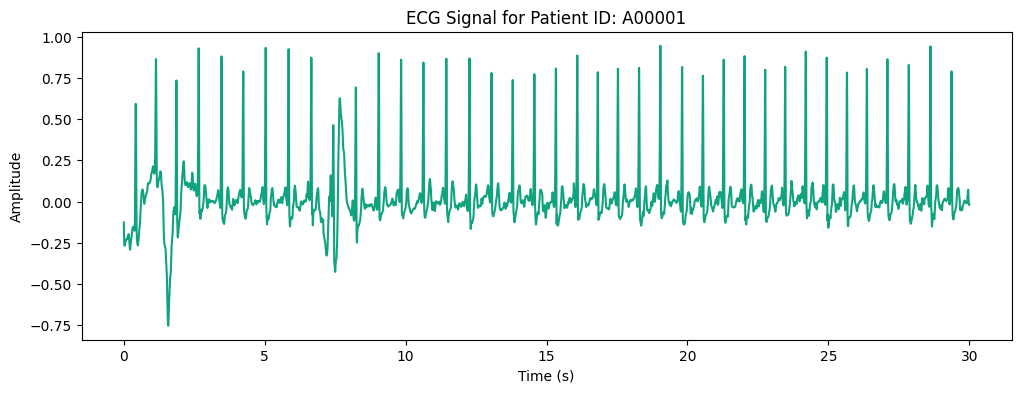

In [5]:
# example A00001
id= 'A00001'
ecg_signal, fs = ecg_read(id)   
time = np.arange(ecg_signal.shape[0]) / fs


# Plot the ECG signals
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, '#10a37f')
plt.title(f'ECG Signal for Patient ID: {id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## 3. Preprocessing ECG Data: PT Algorithm (Optional) 

#### Acknowledgements ####

This project utilizes code from [Pramod07Ch](https://github.com/Pramod07Ch). Their contributions have been invaluable to the development of this project. You can find the original repository [here](https://github.com/Pramod07Ch/Pan-Tompkins-algorithm-python).

In [6]:
from scipy.signal import butter, filtfilt
class Pan_tompkins:
    """ Implementationof Pan Tompkins Algorithm.

    Noise cancellation (bandpass filter) -> Derivative step -> Squaring and integration.

    Params:
        data (array) : ECG data
        sampling rate (int)
    returns:
        Integrated signal (array) : This signal can be used to detect peaks


    ----------------------------------------
    HOW TO USE ?
    Eg.

    ECG_data = [4, 7, 80, 78, 9], sampling  =2000
    
    call : 
       signal = Pan_tompkins(ECG_data, sampling).fit()

    ----------------------------------------
    
    """
    def __init__(self, data, sample_rate):

        self.data = data
        self.sample_rate = sample_rate


    def fit(self, normalized_cut_offs=None, butter_filter_order=2, padlen=150, window_size=None):
        ''' Fit the signal according to algorithm and returns integrated signal
        
        '''
        # 1.Noise cancellationusing bandpass filter
        self.filtered_BandPass = self.band_pass_filter(normalized_cut_offs, butter_filter_order, padlen)
        
        # 2.derivate filter to get slpor of the QRS
        self.derviate_pass = self.derivative_filter()

        # 3.Squaring to enhance dominant peaks in QRS
        self.square_pass = self.squaring()

        # 4.To get info about QRS complex
        self.integrated_signal = self.moving_window_integration( window_size)

        return self.integrated_signal


    def band_pass_filter(self, normalized_cut_offs=None, butter_filter_order=2, padlen=150):
        ''' Band pass filter for Pan tompkins algorithm
            with a bandpass setting of 5 to 20 Hz

            params:
                normalized_cut_offs (list) : bandpass setting canbe changed here
                bandpass filte rorder (int) : deffault 2
                padlen (int) : padding length for data , default = 150
                        scipy default value = 2 * max(len(a coeff, b coeff))

            return:
                filtered_BandPass (array)
        '''

        # Calculate nyquist sample rate and cutoffs
        nyquist_sample_rate = self.sample_rate / 2

        # calculate cutoffs
        if normalized_cut_offs is None:
            normalized_cut_offs = [5/nyquist_sample_rate, 15/nyquist_sample_rate]
        else:
            assert type(self.sample_rate ) is list, "Cutoffs should be a list with [low, high] values"

        # butter coefficinets 
        b_coeff, a_coeff = butter(butter_filter_order, normalized_cut_offs, btype='bandpass')[:2]

        # apply forward and backward filter
        filtered_BandPass = filtfilt(b_coeff, a_coeff, self.data, padlen=padlen)
        
        return filtered_BandPass


    def derivative_filter(self):
        ''' Derivative filter

        params:
            filtered_BandPass (array) : outputof bandpass filter
        return:
            derivative_pass (array)
        '''

        # apply differentiation
        derviate_pass= np.diff(self.band_pass_filter())

       

        return derviate_pass


    def squaring(self):
        ''' squaring application on derivate filter output data

        params:

        return:
            square_pass (array)
        '''

        # apply squaring
        square_pass= self.derivative_filter() **2

        return square_pass 


    def moving_window_integration(self, window_size=None):
        ''' Moving avergae filter 

        Params:
            window_size (int) : no. of samples to average, if not provided : 0.08 * sample rate
            sample_rate (int) : should be given if window_size is not given  
        return:
            integrated_signal (array)
        '''

        if window_size is None:
            assert self.sample_rate is not None, "if window size is None, sampling rate should be given"
            window_size = int(0.08 * int(self.sample_rate))  # given in paper 150ms as a window size
        

        # define integrated signal
        integrated_signal = np.zeros_like(self.squaring())

        # cumulative sum of signal
        cumulative_sum = self.squaring().cumsum()

        # estimationof area/ integral below the curve deifnes the data
        integrated_signal[window_size:] = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

        integrated_signal[:window_size] = cumulative_sum[:window_size] / np.arange(1, window_size + 1)

        return integrated_signal

> example

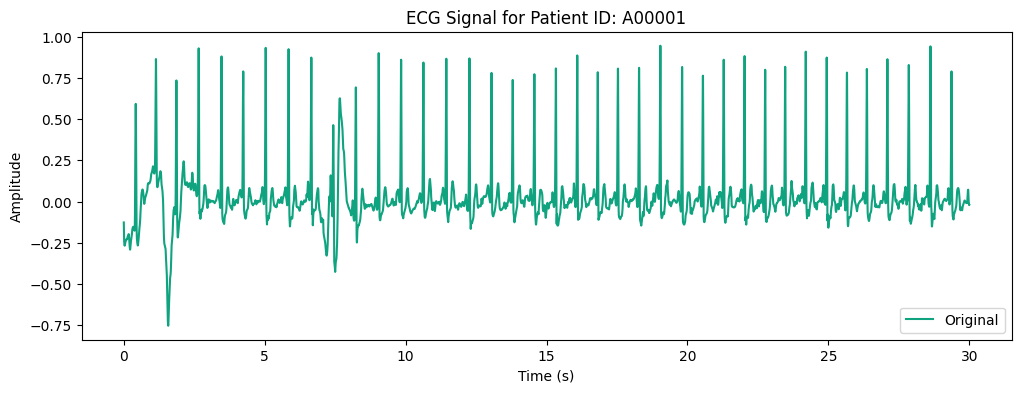

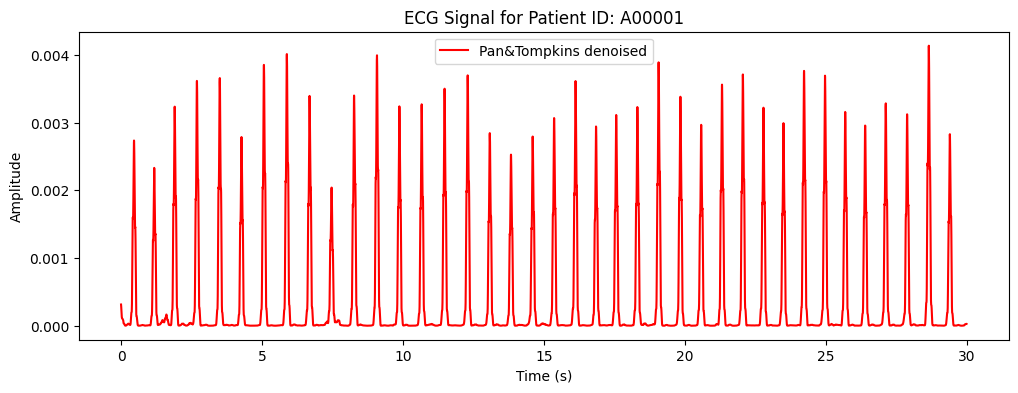

In [7]:
# example A00001
id= 'A00001'
ecg_signal, fs = ecg_read(id)   
time = np.arange(ecg_signal.shape[0]) / fs


# Plot the Original ECG signals
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, '#10a37f', label='Original')
plt.title(f'ECG Signal for Patient ID: {id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# PT Algorithm adapted
pt_tompkins = Pan_tompkins(ecg_signal,fs).fit()
ecg_signal = pt_tompkins
time = np.arange(ecg_signal.shape[0]) / fs

# Plot the Original ECG signals
plt.figure(figsize=(12, 4))
plt.plot(time, ecg_signal, 'red', label='Pan&Tompkins denoised')
plt.title(f'ECG Signal for Patient ID: {id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## 4. Visualization ECG 

### 4-1. ECG to Spectrogram (stft)

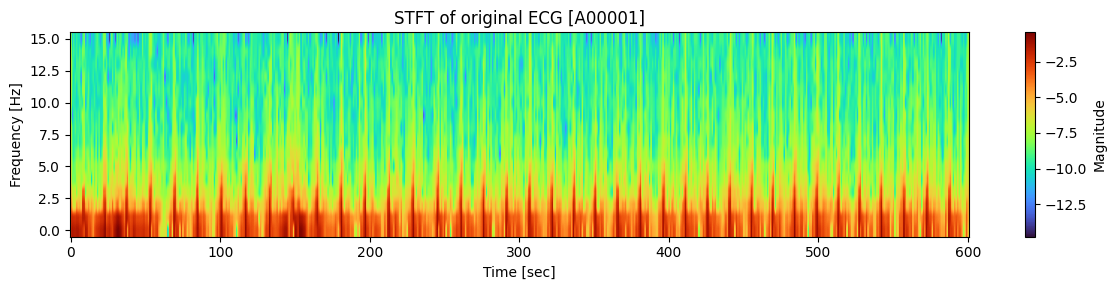

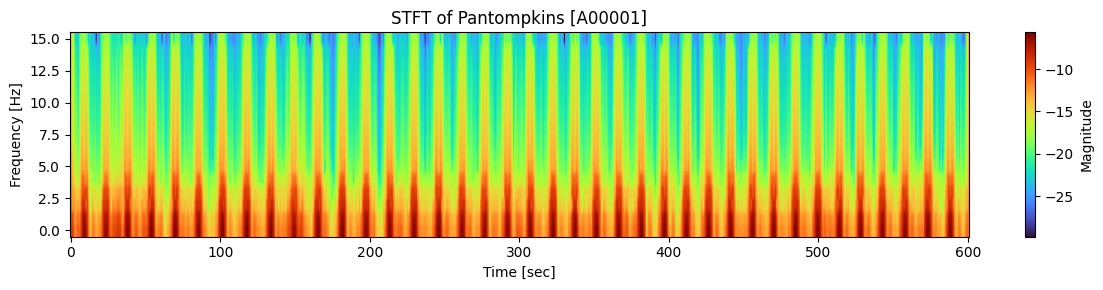

In [8]:
# Example
id = 'A00001'
ecg_signal, fs = ecg_read(id)

# Spectrogram of original signal
window_length = int(0.1 * fs)
frequencies, times, stft = signal.stft(ecg_signal, fs, nperseg=window_length)

plt.figure(figsize=(12, 3))
plt.imshow(np.log(np.abs(stft)), aspect='auto', cmap='turbo', origin='lower')
plt.title(f'STFT of original ECG [{id}]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

# PT Algorithm Denoised
pt_tompkins = Pan_tompkins(ecg_signal, fs).fit()
ecg_signal_denoised = pt_tompkins

# Spectrogram of denoised signal
frequencies, times, pt_stft = signal.stft(ecg_signal_denoised, fs, nperseg=window_length)

plt.figure(figsize=(12, 3))
plt.imshow(np.log(np.abs(pt_stft)), aspect='auto', cmap='turbo', origin='lower')
plt.title(f'STFT of Pantompkins [{id}]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

### 4-2. Cartesian k-Space

In [9]:
import numpy as np
from scipy.interpolate import griddata

def spectrogram_polar_transform(d, grid_resolution ='auto', flipped_up = True, method ='linear'):
    nx, ny = d.shape
   
    # generate_polar_k_space
    radii = np.linspace(0, 1, nx)  # radius
    theta = np.linspace(0, 2 * np.pi, ny)  # theta
    kx_list, ky_list = [], []
    for r in radii:
        kx = r * np.cos(theta)
        ky = r * np.sin(theta)
        kx_list.append(kx)
        ky_list.append(ky)

    kx = np.concatenate(kx_list)
    ky = np.concatenate(ky_list)
    k= kx + 1j*ky
    kx, ky = np.real(k), np.imag(k)

    # 성분 반전
    if flipped_up:
        d = np.flipud(d) 
    
    # resolution
    if grid_resolution == 'auto':
        ndata_points = k.size # polar k-space data point
        radius = np.sqrt(ndata_points / np.pi) # S=2*pi*r
        diameter = 2 * radius # d = 2*r
        n = int(diameter)
        
    elif isinstance(grid_resolution, int):
        n = grid_resolution
    else:
        raise ValueError("grid_resolution must be 'auto' or an integer.")
    

    # interpolation 
    d = np.asarray(d).flatten()
    kx = np.asarray(kx).flatten()
    ky = np.asarray(ky).flatten()    
    grid_x, grid_y = np.mgrid[min(kx):max(kx):complex(n), min(ky):max(ky):complex(n)]
    grid_d = griddata(points=np.column_stack((kx, ky)), values=d, xi=(grid_x, grid_y), method=method)

    return grid_d, grid_x, grid_y

> Processing for Cartesian K-space

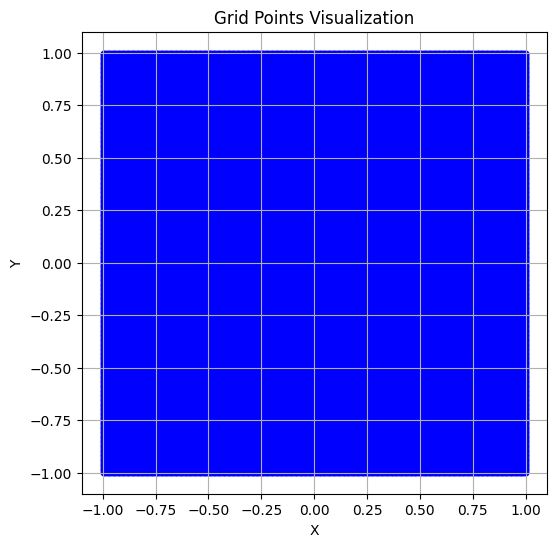

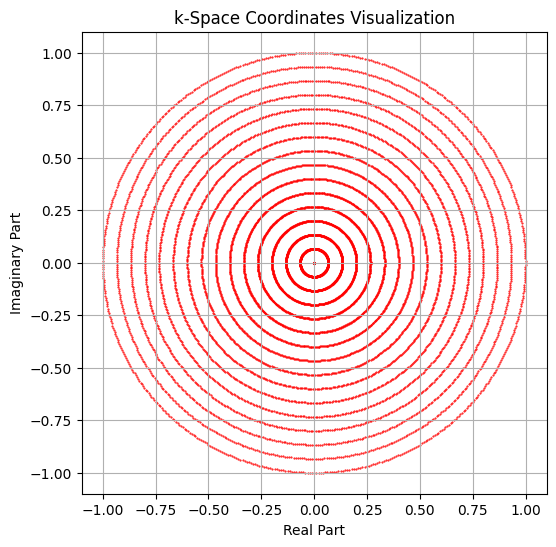

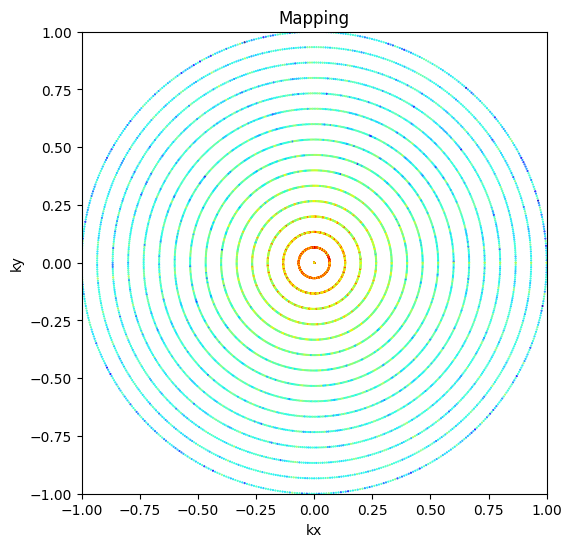

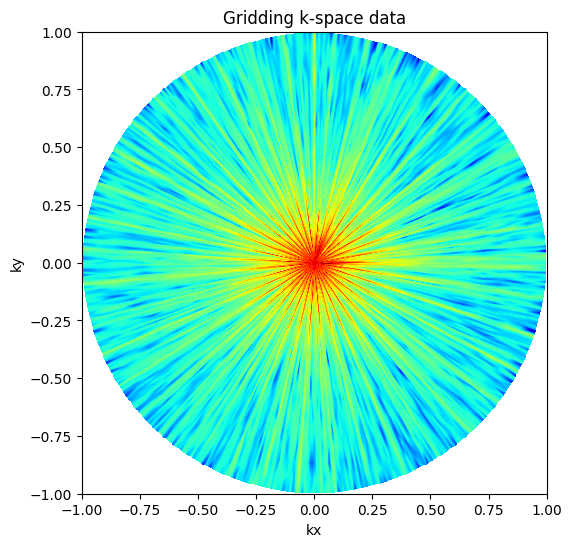

In [17]:
figure_size = (6, 6)

def kspace_data_visualization(grid_d, grid_x, grid_y):
    fig, ax = plt.subplots(figsize=figure_size)
    
    grid_x = grid_x.reshape(grid_d.shape)
    grid_y = grid_y.reshape(grid_d.shape)
    
    extent = [grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()]
    
    ax.imshow(grid_d, extent=extent, origin='lower', cmap='jet', aspect='auto')
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_title('Gridding k-space data')
    plt.show()

def grid_data_visualization(grid_x, grid_y):
    plt.figure(figsize=figure_size)
    plt.scatter(grid_x, grid_y, marker='.', color='blue')
    plt.title('Grid Points Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

marker = '.'
scatter_size = 1
def mapping_data_visualization(kx, ky, d):
    fig, ax = plt.subplots(figsize=figure_size)
    ax.scatter(kx, ky, s=scatter_size, c=d.flatten(), marker=marker, cmap = 'jet')
    ax.set_xlim(min(kx), max(kx))
    ax.set_ylim(min(ky), max(ky))
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_title('Mapping')
    plt.show()


def kspace_coo_visualization(kx, ky):
    plt.figure(figsize=figure_size)
    plt.scatter(kx, ky, s=scatter_size, marker=marker, color='red')
    plt.title('k-Space Coordinates Visualization')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.grid(True)
    plt.show()




ecg_signal, fs = ecg_read('A00001')
window_length = int(0.1 * fs)
stft= signal.stft(ecg_signal,fs, nperseg=window_length)[2]
S =np.log(abs(stft+1e-10))
# raw_k, x1, y1=spectrogram_polar_transform(stft, grid_resolution = 512, flipped_up = True, method = 'linear')

nx, ny = S.shape

# generate_polar_k_space
radii = np.linspace(0, 1, nx)  # radius
theta = np.linspace(0, 2 * np.pi, ny)  # theta
kx_list, ky_list = [], []
for r in radii:
    kx = r * np.cos(theta)
    ky = r * np.sin(theta)
    kx_list.append(kx)
    ky_list.append(ky)

kx = np.concatenate(kx_list)
ky = np.concatenate(ky_list)


k= kx + 1j*ky
kx, ky = np.real(k), np.imag(k)

# interpolation 
n= 512
method='linear'

S = np.asarray(S).flatten()
kx = np.asarray(kx).flatten()
ky = np.asarray(ky).flatten()    
grid_x, grid_y = np.mgrid[min(kx):max(kx):complex(n), min(ky):max(ky):complex(n)]
grid_d = griddata(points=np.column_stack((kx, ky)), values=S, xi=(grid_x, grid_y), method=method)


grid_data_visualization(grid_x, grid_y)
kspace_coo_visualization(kx, ky)
mapping_data_visualization(kx, ky, S)
kspace_data_visualization(grid_d, grid_x, grid_y)


# plt.imshow(np.log(np.abs(S)), aspect='auto', cmap= 'jet', origin='lower')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.tight_layout()
# plt.show()

> example

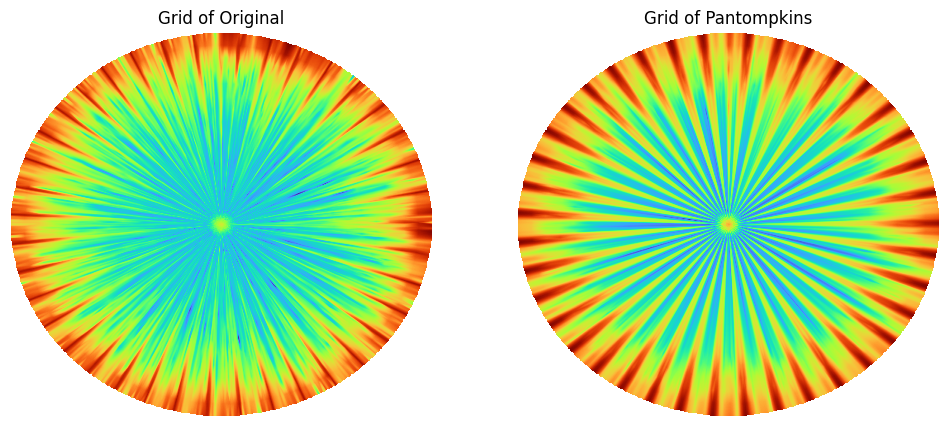

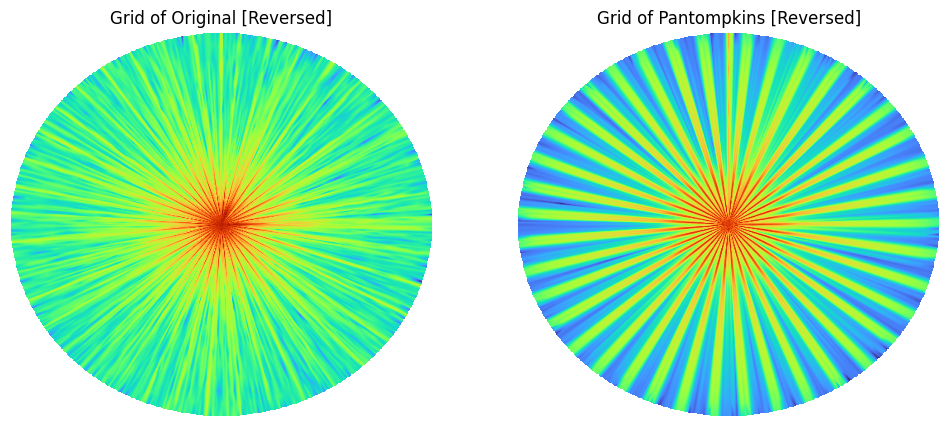

In [11]:

# Example
id = 'A00001'
ecg_signal, fs = ecg_read(id)

# Spectrogram of original signal
window_length = int(0.1 * fs)
frequencies, times, stft = signal.stft(ecg_signal, fs, nperseg=window_length)


# PT Algorithm Denoised
pt_tompkins = Pan_tompkins(ecg_signal, fs).fit()
ecg_signal_denoised = pt_tompkins

# Spectrogram of denoised signal
frequencies, times, pt_stft = signal.stft(ecg_signal_denoised, fs, nperseg=window_length)

# # logscale
stft =np.log(abs(stft+1e-10))
pt_stft =np.log(abs(pt_stft+1e-10))


# kspace
raw_k, x1, y1=spectrogram_polar_transform(stft, grid_resolution = 512, flipped_up = True, method = 'linear')
pt_k, x2, y2=spectrogram_polar_transform(pt_stft, grid_resolution = 512, flipped_up = True, method = 'linear')
       

# K-Space plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

# polar raw_stft
extent1 = [x1.min(), x1.max(), y1.min(), y1.max()]
cax1 = axs[0].imshow(raw_k, extent=extent1, origin='lower', cmap='turbo', aspect='auto')
axs[0].set_title('Grid of Original')
axs[0].axis('off')  

# polar pt_stft
extent2 = [x2.min(), x2.max(), y2.min(), y2.max()]
cax3 = axs[1].imshow(pt_k, extent=extent2, origin='lower', cmap='turbo', aspect='auto')
axs[1].set_title('Grid of Pantompkins')
axs[1].axis('off')  

### reversed ####
raw_k, x1, y1=spectrogram_polar_transform(stft, grid_resolution = 512, flipped_up = False, method = 'linear')
pt_k, x2, y2=spectrogram_polar_transform(pt_stft, grid_resolution = 512, flipped_up = False, method = 'linear')

# K-Space plot    
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

#  polar raw_stft
extent1 = [x1.min(), x1.max(), y1.min(), y1.max()]
cax1 = axs[0].imshow(raw_k, extent=extent1, origin='lower', cmap='turbo', aspect='auto')
axs[0].set_title('Grid of Original [Reversed]')
axs[0].axis('off')  

# polar pt_stft
extent3 = [x2.min(), x2.max(), y2.min(), y2.max()]
cax3 = axs[1].imshow(pt_k, extent=extent3, origin='lower', cmap='turbo', aspect='auto')
axs[1].set_title('Grid of Pantompkins [Reversed]')
axs[1].axis('off')  



plt.show()

## 5. Save Polar Image

> Save Function

Parameter
- 1. dpi
- 2. image size (224x224)
- 3. Denoising (PT or not)
- 4. Flipped_up (T/F)
- 5. Grid resoultion (2~1024)
- 6. Interpolation (Linear/Cubic)
- 7. Scatter point size (1-10)    
- 8. [optional] vim & vmax

We used the image files generated from this script to perform classification tasks using the CNN model from [WingMaster22](https://github.com/WingMaster22). Their contributions have been invaluable to the development of this project. You can find the original repository [here](https://github.com/WingMaster22/polar-spectrogram-model).


In [12]:
import matplotlib.pyplot as plt

def save(grid_d, grid_x, grid_y, save_path, id, image_size=(224, 224)):
    
    figure_size = (6, 6)
    # Calculate figure size in inches (width, height) to achieve desired image size in pixels
    dpi = 1000  # Set the DPI to 224 for high-resolution output
    fig_size_inch = (image_size[0] / dpi, image_size[1] / dpi)
    fig, ax = plt.subplots(figsize=fig_size_inch, dpi=dpi)
    
    # Reshape the grid_x and grid_y if necessary
    grid_x = grid_x.reshape(grid_d.shape)
    grid_y = grid_y.reshape(grid_d.shape)
    
    # Set the extent of the image
    extent = [grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()]
    
    # Display the image
    ax.imshow(grid_d, extent=extent, origin='lower', cmap='jet', aspect='auto', vmin=-18, vmax= -8 )
    
    # Remove axis lines, labels, and ticks
    ax.axis('off')
    
    # Ensure there is no padding and no border around the image
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    ax.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Save the figure as a PNG image with a transparent background
    plt.savefig(f'{save_path}\\{id}.png', format='png', transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()



> Save Polar Image

In [13]:
# for label, patient_ids in dic.items():
#     # Make director for each class
#     if label =="Atrial Fibrillation" :
#         folder_name = "A"
        
#     if label =="Normal Sinus Rhythm" :
#         folder_name = "N"

#     if label =="Other Rhythm" :
#         folder_name = "O"
        
#     if label =="Noisy" :
#         folder_name = "~"

#     if not os.path.exists(folder_name):
#         os.makedirs(folder_name)

#     for patient_id in patient_ids:
        
#         save_filename = f'{patient_id}.png'
#         save_path = os.path.join(folder_name, save_filename)
        
#         if os.path.exists(save_path):
#             # IF the Img file exists, pass it!!!!!!
#             continue
        
#         ecg_signal, fs = ecg_read(patient_id)   

#         # PT Algorithm적용
#         pt_tompkins = Pan_tompkins(ecg_signal,fs).fit()
#         ecg_signal = pt_tompkins

#         # stft (Option 1 for making spectrogram)
#         window_length = int(0.1 * fs)
#         S = signal.stft(ecg_signal,fs, nperseg=window_length)[2]

#         #spectrogram (Option 2 for making spectrogram)
#         # window_length = int(0.1 * fs)
#         # S = signal.spectrogram(ecg_signal,fs, nperseg=window_length)[2]

#         # grid
#         s, x, y=spectrogram_polar_transform(np.log(np.abs(S)+1e-10), grid_resolution = 512, flipped_up = True, method = 'linear')

#         # Save the transformed spectrogram with the appropriate label and patient ID
#         save_path = os.path.join(folder_name)  # The directory where the image will be saved
        
#         save(s, x, y, save_path, patient_id )
         
        

> Img Count

In [14]:
# import os

# # directory lists
# folders = ["A", "N", "O", "~"]

# # Counting function
# def count_png_files(folder_name):
#     count = 0
#     
#     if os.path.exists(folder_name):
#         
#         for file in os.listdir(folder_name):
#             
#             if file.endswith(".png"):
#                 count += 1
#     return count

# # Printing the numbers of Images in each directory 
# total=0
# for folder in folders:
#     png_count = count_png_files(folder)
#     total= png_count+ total
#     print(f"Folder '{folder}': {png_count} PNG files")

# print(total)    

> Example for saving image

In [15]:
# # ecg read
# # afib : 67
# # noise : 6223
# # other : 400, 544, 556

# id = 'A00001'
# ecg_signal, fs = ecg_read(id)
# time = np.arange(0, len(ecg_signal))/fs

# # # PT Algorithm적용
# pt_tompkins = Pan_tompkins(ecg_signal,fs).fit()
# ecg_signal = pt_tompkins
# time = np.arange(0, len(ecg_signal))/fs

# # stft
# window_length = int(0.1 * fs)
# frequencies, times, S = signal.spectrogram(ecg_signal, fs, nperseg=window_length)

# # grid
# s, x, y=spectrogram_polar_transform(np.log(np.abs(S)), grid_resolution = 512, flipped_up = False, method = 'linear')
# # s, x, y=spectrogram_polar_transform(np.log(np.abs(S+1e-10)), grid_resolution = 512, flipped_up = True, method = 'linear')


# save_path = 'c:\\Users\\Desktop'

# for label, patient_ids in dic.items():
#     if id in patient_ids:
#         if label == "Atrial Fibrillation":
#             record_id = f'{label} {id}'
#         elif label == "Normal Sinus Rhythm":
#             record_id = f'{label} {id}'
#         elif label == "Other Rhythm":
#             record_id = f'{label} {id}'
#         elif label == "Noisy":
#             record_id = f'{label} {id}'
        

# # plt.figure(figsize=(10, 4))
# # plt.plot(time, ecg_signal)

# # plt.xlim(time[0], time[-1])
# # plt.gca().set_axis_off()
# # plt.savefig(f'{save_path}/ECG_Signal_{record_id}.png', bbox_inches='tight', pad_inches=0)
# # plt.close()

# # # STFT plot
# # plt.figure(figsize=(15, 3))
# # plt.pcolormesh(times, frequencies, np.log(np.abs(S)), shading='auto', cmap='jet')

# # plt.gca().set_axis_off()
# # plt.savefig(f'{save_path}/STFT_{record_id}.png', bbox_inches='tight', pad_inches=0)
# # plt.close()

# # Polar plot
# fig, ax = plt.subplots(figsize=(6, 6))
# extent = [x.min(), x.max(), y.min(), y.max()]
# cax = ax.imshow(s, extent=extent, origin='lower', cmap='jet', aspect='auto')

# ax.set_axis_off()
# # plt.savefig(f'{save_path}/Polar_STFT_{record_id}.png', bbox_inches='tight', pad_inches=0)
# plt.close()

# # ecg plot
# # plt.figure(figsize=(10, 4))
# # plt.plot(time,ecg_signal)
# # plt.title(f'ECG Signal: {record_id}')
# # plt.xlabel('Time')
# # plt.ylabel('Amplitude')
# # plt.xlim(time[0], time[-1])
# # # plt.ylim(1.5, -1.5)  
# # plt.tight_layout()
# # plt.show()


# # # # stft plot
# # # plt.figure(figsize=(15, 3))
# # # # plt.imshow(np.log(np.abs(S)), aspect='auto', cmap= 'jet', origin='lower')
# # # plt.pcolormesh(times, frequencies, np.log(np.abs(S)), shading='gouraud', cmap='jet')
# # # # plt.pcolormesh(times, frequencies, np.log(np.abs(S+1e-10)), shading='auto', cmap='jet')
# # # plt.title(f'STFT: {record_id}')
# # # plt.title(f'STFT: {record_id}')
# # # plt.ylabel('Frequency')
# # # plt.xlabel('Time')
# # # plt.show()

# # # # polar plot
# # fig, ax = plt.subplots(figsize=(6,6))
# # extent = [x.min(), x.max(), y.min(), y.max()]
# # cax= ax.imshow(s, extent=extent, origin='lower', cmap='jet', aspect='auto')

# # ax.set_xlabel('kx')
# # ax.set_ylabel('ky')
# # ax.set_title(f'Polar STFT:{record_id}')
# # # fig.colorbar(cax, format='%+2.0f dB')
# # plt.show()

## 6. GUI

In [16]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output
from scipy.signal import spectrogram, get_window, welch
import numpy as np
def update_plot(patient_id, time_range, window_length, cmap, reverse):
        
        
        ecg_signal, fs = ecg_read(patient_id)
        
        # PT Algorithm적용
        pt_tompkins = Pan_tompkins(ecg_signal,fs).fit()
        pt_signal = pt_tompkins
      
    

        #슬라이드에 따라 시간 설정
        start, end = time_range
        start_index = int(start * fs)
        end_index = int(end * fs)
        
        # STFT 계산
        window_length = int(window_length * fs)
        raw_stft = signal.stft(ecg_signal[start_index:end_index], fs=fs, nperseg=window_length)[2] 
        pt_stft = signal.stft(pt_signal[start_index:end_index], fs=fs, nperseg=window_length)[2]  
        
        
        # # logscale
        raw_stft =np.log(abs(raw_stft+1e-10))
        pt_stft =np.log(abs(pt_stft+1e-10))
                

        # K-space transformation
        flipped_up = False if reverse == 'Yes' else True

        # kspace
        raw_k, x1, y1=spectrogram_polar_transform(raw_stft, grid_resolution = 512, flipped_up = flipped_up, method = 'linear')
        pt_k, x2, y2=spectrogram_polar_transform(pt_stft, grid_resolution = 512, flipped_up = flipped_up, method = 'linear')
       
        # ECG plot
        plt.figure(figsize=(15, 3))
        plt.subplot(121)
        plt.plot(ecg_signal[start_index:end_index], label="Original Signal")
        time_ticks = np.linspace(start_index, end_index, 5)
        time_labels = [f"{int(x/fs)}" for x in time_ticks]
        plt.xticks(ticks=time_ticks, labels=time_labels)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('Original Signal')
        plt.legend()

        plt.subplot(122)
        plt.plot(pt_signal[start_index:end_index], label="Pantompkins Denoise")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title('PT-Denoised')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # STFT plot
        plt.figure(figsize=(15, 3))
        plt.subplot(121)
        plt.imshow(raw_stft, aspect='auto', cmap=cmap, origin='lower')
        plt.title('STFT of Original')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(label='Magnitude')

        plt.subplot(122)
        plt.imshow(pt_stft, aspect='auto', cmap=cmap, origin='lower')
        plt.title('STFT of Pantompkins')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(label='Magnitude')
        plt.tight_layout()
        plt.show()

        # K-Space plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))  
      
        
        # Polar raw_stft
        extent1 = [x1.min(), x1.max(), y1.min(), y1.max()]
        cax1 = axs[0].imshow(raw_k, extent=extent1, origin='lower', cmap=cmap, aspect='auto')
        title1 = 'Grid of Original [Reversed]' if reverse == 'Yes' else 'Grid of Original'
        axs[0].set_title(title1)
        axs[0].axis('off')  

        # Polar pt_stft
        extent2 = [x2.min(), x2.max(), y2.min(), y2.max()]
        cax2 = axs[1].imshow(pt_k, extent=extent2, origin='lower', cmap=cmap, aspect='auto')
        title2 = 'Grid of Pantompkins [Reversed]' if reverse == 'Yes' else 'Grid of Pantompkins'
        axs[1].set_title(title2)
        axs[1].axis('off')  

        plt.show()
            
        # # plot Iris

        # Polar cartesican
        # theta = -np.linspace(-np.pi, np.pi, len(times))
        # # rho = np.max()/3 + frequencies
        # rho =np.linspace(0, np.max(frequencies), len(frequencies))
        # T, R = np.meshgrid(theta, rho)
        # X, Y = R * np.cos(T), R * np.sin(T)


        # plt.clf()
        # plt.figure(figsize=(15, 3))
        # plt.subplot(121)
        # plt.pcolormesh(X,Y, np.flipud(raw_stft), shading='gouraud', cmap=cmap)
        # plt.axis('image')
        # plt.axis('off')
        # plt.title('Iris of Original')
        
    
        # plt.subplot(122)
        # plt.pcolormesh(X,Y, np.flipud(pt_stft), shading='gouraud', cmap=cmap)
        # plt.axis('image')
        # plt.axis('off')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Iris of Pantompkins')
        # plt.show()


        
   
dic = {'Atrial Fibrillation': A, 'Normal Sinus Rhythm': N, 'Other Rhythm': O, 'Noisy': I}
# 레이블 선택을 위한 드롭다운 위젯
label_dropdown = widgets.Dropdown(
    options=list(dic.keys()),
    description='ECG Label:',
)

# 환자 ID 선택을 위한 두 번째 드롭다운 (초기화는 빈 상태) 
patient_dropdown = widgets.Dropdown(
    options=[],
    description='ID:',
)


# 슬라이더 생성
time_slider = widgets.IntRangeSlider(
    
    value=[0, 30],
    min=0,
    max=30,  # 초기 최대값 설정
    step=0.5,
    description='Time Range (s):',
    continuous_update=False
)
# Amplitude에 기여



# 샘플링 촘촘함과 연결, 기하학적인 요인
window_length_slider = widgets.FloatSlider(
    value=0.1,  # Default value
    min=0,    # Minimum value
    max=5.0,    # Maximum value (1 second)
    step=0.005,
    description='Win-len (Hz):',
    continuous_update=False
)

# 색상 맵을 위한 드롭다운 위젯 생성
cmap_dropdown = widgets.Dropdown(
    options=['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'twilight', 'jet', 'turbo', 'bone', 'hot', 'cool'],
    value='jet',  # 기본값 설정
    description='Color Map:',
)

reverse_dropdown = widgets.Dropdown(
    options=['No', 'Yes'],
    value='No',
    description='Reverse:',
)

slider_box = widgets.VBox([time_slider,window_length_slider])


# 환자 ID가 선택되었을 때 ECG를 플롯하는 함수
def update_patient_dropdown(*args):
    label = label_dropdown.value
    patient_dropdown.options = dic[label]

label_dropdown.observe(update_patient_dropdown, 'value')
def on_patient_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(widgets.HBox([label_dropdown, patient_dropdown]))
        patient_id = change['new']
        
        # 슬라이더의 최대 범위를 ECG 신호의 길이에 맞게 업데이트
        ecg_signal, fs = ecg_read(patient_id)
        max_time = len(ecg_signal) / fs  # 시간 단위로 변환
        time_slider.max = max_time
        time_slider.value = [0, max_time]
      
        

        # interact 함수를 사용하여 위젯과 update_plot 함수 연결
        interact_plot = interact(update_plot, patient_id=widgets.fixed(patient_id), time_range=time_slider, window_length=window_length_slider, cmap=cmap_dropdown, reverse=reverse_dropdown)
        display(interact_plot)

patient_dropdown.observe(on_patient_dropdown_change, 'value')
display(widgets.HBox([label_dropdown, patient_dropdown]))



interactive(children=(IntRangeSlider(value=(0, 30), continuous_update=False, description='Time Range (s):', ma…

<function __main__.update_plot(patient_id, time_range, window_length, cmap, reverse)>